# Relax Inc. Take-Home Challenge, Daniel Loew, Springboard

The Relax Inc. take-home challenge focuses on predicting customer adoption of the platform using a set of user characteristics.

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline
import sklearn
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pickle

In [2]:
data_path = '/Users/DanLoew/Documents/Academia/Springboard/DSCT/17.2.3 Relax Inc Take Home Challenge/relax_challenge/takehome_users.csv'
df = pd.read_csv(data_path, index_col='object_id', encoding='latin_1')

In [3]:
df.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
object_id,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 9 columns):
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(3), object(4)
memory usage: 937.5+ KB


In [5]:
df.describe(include='all')

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000,12000,12000,12000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000
unique,11996,11355,11980,5,NaN,NaN,NaN,NaN,NaN
top,2012-09-01 07:22:09,Araujo Gabriela,AlfieLane@yahoo.com,ORG_INVITE,NaN,NaN,NaN,NaN,NaN
freq,2,5,2,4254,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,1.379279e+09,0.249500,0.149333,141.884583,5962.957145
std,NaN,NaN,NaN,NaN,1.953116e+07,0.432742,0.356432,124.056723,3383.761968
min,NaN,NaN,NaN,NaN,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,NaN,NaN,NaN,NaN,1.363195e+09,0.000000,0.000000,29.000000,3058.000000
50%,NaN,NaN,NaN,NaN,1.382888e+09,0.000000,0.000000,108.000000,5954.000000
75%,NaN,NaN,NaN,NaN,1.398443e+09,0.000000,0.000000,238.250000,8817.000000


In [6]:
df.shape

(12000, 9)

In [7]:
df.isnull().sum()

creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

In [8]:
df.isna().sum()

creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

In [9]:
12000 - 5583

6417

In [10]:
df['creation_source'].value_counts()

ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

In [11]:
4254 + 2163

6417

In order for the machine learning to work, there can be no missing values. As is seen above, 3,177 users have no value for 'last_session_creation_time'. These missing values illustrate users who created their account and never logged in again. Therefore, their value for 'last_session_creation_time' will be changed from 'nan' to the median value for that column. 

5,583 users have a missing value for the 'invited_by_user_id' variable, because these users weren't invited by a specific org or guest, as illustrated in the 'value_counts' and math cells above. Therefore, these users will have their missing value for 'invited_by_user_id' changed to 'not_invited_by_org_or_user'.

For each of the two features with missing values, a partner binary feature will be created which will flag which rows had their missing values filled in.

In [12]:
null_value_columns = list(df.columns[(df.isnull().sum()>0) | (df.isna().sum()>0)])
null_value_columns

['last_session_creation_time', 'invited_by_user_id']

In [13]:
for col_name in null_value_columns:
    new_col_name = col_name+'_isnull'
    print(col_name)
    df[new_col_name] = df[col_name].isnull()

last_session_creation_time
invited_by_user_id


In [14]:
df.head(1)

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,last_session_creation_time_isnull,invited_by_user_id_isnull
object_id,,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False,False


In [15]:
last_session_creation_time_median = df['last_session_creation_time'].median()
last_session_creation_time_median

1382888470.0

In [16]:
df['last_session_creation_time'] = df['last_session_creation_time'].fillna(value = last_session_creation_time_median)

In [17]:
fill_invited_by_user_id = ['invited_by_user_id']

In [18]:
df[fill_invited_by_user_id] = df[fill_invited_by_user_id].fillna(value=0, axis=1)

All missing values have been filled.

In [19]:
null_value_columns = list(df.columns[(df.isnull().sum()>0) | (df.isna().sum()>0)])
null_value_columns

[]

Frequency distributions of all features are examined for obviously erroneous values.

In [20]:
df['creation_time'].value_counts()

2012-09-01 07:22:09    2
2014-02-11 17:57:53    2
2012-09-14 21:35:03    2
2013-05-25 04:35:52    2
2014-03-12 01:46:02    1
2014-05-18 07:58:14    1
2014-04-29 14:02:21    1
2013-06-18 06:16:26    1
2012-06-21 05:56:23    1
2013-01-30 12:45:39    1
2013-05-27 13:59:31    1
2013-10-26 20:11:44    1
2014-03-18 09:57:25    1
2012-07-20 23:56:45    1
2014-01-20 07:46:58    1
2012-08-16 10:31:23    1
2012-07-18 23:31:38    1
2013-06-09 02:38:11    1
2013-08-21 15:08:21    1
2012-08-06 09:11:02    1
2014-05-26 07:06:29    1
2013-01-12 22:39:52    1
2013-03-31 20:03:08    1
2014-01-11 01:42:28    1
2013-02-07 02:31:15    1
2013-12-05 10:08:12    1
2013-06-14 08:41:36    1
2014-05-27 21:45:15    1
2012-10-31 12:37:23    1
2014-01-07 13:29:49    1
                      ..
2013-05-13 19:01:53    1
2012-10-21 22:13:00    1
2013-01-11 11:52:35    1
2014-02-02 13:43:10    1
2012-07-04 11:08:10    1
2013-12-29 22:14:29    1
2013-04-15 19:30:51    1
2014-05-22 12:57:12    1
2012-09-11 22:44:04    1


In [21]:
df['name'].value_counts()

Araujo Gabriela      5
Cavalcanti Victor    5
Azevedo Clara        4
Costa Lavinia        4
Correia Leonardo     4
Souza Alice          4
Azevedo Bruna        4
Carvalho Bruna       4
Cunha Melissa        4
Costa Alice          4
Souza Fernanda       4
Pinto Isabela        3
Correia Matilde      3
Sousa Luan           3
Ferreira Rodrigo     3
Martins Isabela      3
Correia Leonor       3
Castro Matheus       3
Barbosa Mateus       3
Santos Emily         3
Pereira Brenda       3
Oliveira Rafael      3
Bang Alberte         3
Carvalho Carolina    3
Rodrigues Sarah      3
Melo Amanda          3
Sousa Paulo          3
Lima Emily           3
Barbosa Felipe       3
Cavalcanti Alice     3
                    ..
Heaney Steven        1
Bach Andrea          1
Jepsen Line          1
Cawthorne Alana      1
Oates Philip         1
Krüger Florian       1
Pickworth Chloe      1
Urner Klaus          1
Nussbaum Julia       1
Robinson Noel        1
Francis Bethany      1
Cardoso Kauê         1
Lund Michae

In [22]:
df['email'].value_counts()

AlfieLane@yahoo.com                   2
PaigeWyatt@gmail.com                  2
JaninaSankt@gmail.com                 2
UlrikeGerste@gmail.com                2
ThomasBrandt@gmail.com                2
AmandaABach@gmail.com                 2
KerstinNeudorf@gmail.com              2
KristinKappel@yahoo.com               2
LaerkeMBertelsen@gmail.com            2
MaximilianWalter@gmail.com            2
MarkoSeiler@yahoo.com                 2
LasseLNrgaard@gmail.com               2
MandySchroder@gustr.com               2
TomSchiffer@gmail.com                 2
MagnusSWinther@jourrapide.com         2
LeonieDuerr@gmail.com                 2
JacobTye@gmail.com                    2
KlausMueller@gustr.com                2
NicolaiSHolm@yahoo.com                2
MimirMKarlsen@jourrapide.com          2
EmilyAlmeidaFernandes@gmail.com       1
LivaPSchmidt@gmail.com                1
MaxCampbell@cuvox.de                  1
AnnaStrauss@gmail.com                 1
SofieMFrederiksen@cuvox.de            1


In [23]:
df['creation_source'].value_counts()

ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

In [24]:
df['last_session_creation_time'].value_counts()

1.382888e+09    3178
1.401917e+09       2
1.401868e+09       2
1.401014e+09       1
1.369762e+09       1
1.354298e+09       1
1.377565e+09       1
1.400788e+09       1
1.387847e+09       1
1.387843e+09       1
1.354284e+09       1
1.380393e+09       1
1.387836e+09       1
1.354275e+09       1
1.387828e+09       1
1.346755e+09       1
1.400790e+09       1
1.354262e+09       1
1.354303e+09       1
1.387863e+09       1
1.387805e+09       1
1.354310e+09       1
1.399306e+09       1
1.354314e+09       1
1.387875e+09       1
1.354326e+09       1
1.387882e+09       1
1.354330e+09       1
1.384894e+09       1
1.387897e+09       1
                ... 
1.365626e+09       1
1.378765e+09       1
1.399191e+09       1
1.349438e+09       1
1.399195e+09       1
1.399198e+09       1
1.366827e+09       1
1.365653e+09       1
1.365657e+09       1
1.365658e+09       1
1.399217e+09       1
1.365668e+09       1
1.399224e+09       1
1.399230e+09       1
1.399272e+09       1
1.399231e+09       1
1.399233e+09 

In [25]:
df['opted_in_to_mailing_list'].value_counts()

0    9006
1    2994
Name: opted_in_to_mailing_list, dtype: int64

In [26]:
df['enabled_for_marketing_drip'].value_counts()

0    10208
1     1792
Name: enabled_for_marketing_drip, dtype: int64

In [27]:
df['org_id'].value_counts()

0      319
1      233
2      201
3      168
4      159
6      138
5      128
9      124
7      119
10     104
8       97
14      87
11      75
12      75
17      74
18      73
13      72
16      72
20      68
15      64
24      63
25      62
28      61
23      60
30      59
22      58
33      57
40      57
21      56
27      55
      ... 
399     13
410     13
322     12
387     12
346     12
407     12
295     12
354     12
344     12
405     12
381     12
356     12
301     12
232     12
364     11
183     11
365     11
352     10
353     10
294     10
378     10
304     10
395      9
315      9
355      9
396      9
400      8
397      8
386      7
416      2
Name: org_id, Length: 417, dtype: int64

In [28]:
df['invited_by_user_id'].value_counts()

0.0        5583
10741.0      13
2527.0       12
1525.0       11
2308.0       11
11770.0      11
4612.0       10
7012.0       10
10481.0      10
4803.0       10
6370.0       10
4302.0       10
8068.0       10
1175.0       10
2354.0       10
10628.0      10
2922.0        9
8426.0        9
6645.0        9
9023.0        9
6493.0        9
3721.0        9
9434.0        9
3789.0        9
6808.0        9
3944.0        9
7698.0        9
4551.0        9
7716.0        9
8554.0        9
           ... 
644.0         1
8152.0        1
294.0         1
1944.0        1
7879.0        1
7587.0        1
5938.0        1
8139.0        1
11857.0       1
5885.0        1
1875.0        1
8890.0        1
1784.0        1
1509.0        1
3928.0        1
2831.0        1
1158.0        1
7348.0        1
2578.0        1
4747.0        1
7658.0        1
3455.0        1
5454.0        1
1586.0        1
11293.0       1
7941.0        1
4134.0        1
6101.0        1
129.0         1
594.0         1
Name: invited_by_user_id

There are no erroneous values that need to be corrected or imputed.

## Transformation of Date Features for Machine Learning Purposes

The date features are unpacked into component integer features, as that is the only way they will be processed by the machine learning model.

In [29]:
df['creation_time'].head(1)

object_id
1    2014-04-22 03:53:30
Name: creation_time, dtype: object

In [30]:
df['creation_time'] = pd.to_datetime(df['creation_time'])
df['creation_time'].head(1)

object_id
1   2014-04-22 03:53:30
Name: creation_time, dtype: datetime64[ns]

In [31]:
df['creation_time_year'] = df['creation_time'].dt.year
df['creation_time_year'].head(1)

object_id
1    2014
Name: creation_time_year, dtype: int64

In [32]:
df['creation_time_month'] = df['creation_time'].dt.month
df['creation_time_month'].head(1)

object_id
1    4
Name: creation_time_month, dtype: int64

In [33]:
df['creation_time_day'] = df['creation_time'].dt.day
df['creation_time_day'].head(1)

object_id
1    22
Name: creation_time_day, dtype: int64

In [34]:
df['creation_time_hour'] = df['creation_time'].dt.hour
df['creation_time_hour'].head(1)

object_id
1    3
Name: creation_time_hour, dtype: int64

In [35]:
df['creation_time_minute'] = df['creation_time'].dt.minute
df['creation_time_minute'].head(1)

object_id
1    53
Name: creation_time_minute, dtype: int64

In [36]:
df['creation_time_seconds'] = df['creation_time'].dt.second
df['creation_time_seconds'].head(1)

object_id
1    30
Name: creation_time_seconds, dtype: int64

Because all of the datetime components have been extracted into separate features, and because the machine learning model won't be able to work with a datetime feature, the 'creation_time' feature is dropped from the DataFrame. First, a separate .csv file is exported so that the distribution of the 'creation_source' variable can be more easily visualized below.

In [37]:
df.to_csv('relax_4_creation_source_viz.csv')

In [38]:
df = df.drop(columns = 'creation_time')

## Binarization of Categorical Features

In order for the machine learning model to work, all categorical features need to be transformed into binary features. In other words, they need to be binarized. This is accomplished using pandas' '.get_dummies()' method.

In [39]:
df = pd.get_dummies(df, columns = ['creation_source'])
df.head(1)

,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,last_session_creation_time_isnull,invited_by_user_id_isnull,creation_time_year,creation_time_month,creation_time_day,creation_time_hour,creation_time_minute,creation_time_seconds,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
object_id,,,,,,,,,,,,,,,,,,,,
1,Clausen August,AugustCClausen@yahoo.com,1.398139e+09,1,0,11,10803.0,False,False,2014,4,22,3,53,30,1,0,0,0,0


## Creation of Target Variable Using SQL and 'takehome_user_engagement' file

In order to create the binary target variable 'adopted_user', user data needs to be merged in to identify those users who have ever logged into the product on three separate days in at least one seven-day period. Therefore, the 'takehome_user_engagement' file is read in and PyMySQL is used to merge it with the main DataFrame and identify adopted users through SQL window counting methods.

In [40]:
df_eng_data_path = '/Users/DanLoew/Documents/Academia/Springboard/DSCT/17.2.3 Relax Inc Take Home Challenge/relax_challenge/takehome_user_engagement.csv'
df_eng = pd.read_csv(df_eng_data_path)

In [41]:
df_eng.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [42]:
df_eng.tail()

,time_stamp,user_id,visited
207912,2013-09-06 06:14:15,11996,1
207913,2013-01-15 18:28:37,11997,1
207914,2014-04-27 12:45:16,11998,1
207915,2012-06-02 11:55:59,11999,1
207916,2014-01-26 08:57:12,12000,1


In [43]:
df_eng['visited'].value_counts()

1    207917
Name: visited, dtype: int64

In [44]:
df_eng['time_stamp_dt'] = pd.to_datetime(df_eng['time_stamp'])
df_eng['time_stamp_dt'].head(1)

0   2014-04-22 03:53:30
Name: time_stamp_dt, dtype: datetime64[ns]

In [45]:
df_eng['time_stamp_ymd'] = df_eng['time_stamp_dt'].dt.to_period('D')
df_eng['time_stamp_ymd'].head(1)

0    2014-04-22
Name: time_stamp_ymd, dtype: period[D]

In [46]:
df_eng.head(1)

,time_stamp,user_id,visited,time_stamp_dt,time_stamp_ymd
0,2014-04-22 03:53:30,1,1,2014-04-22 03:53:30,2014-04-22


In [47]:
date1_ls = list(pd.date_range(start='2012-05-31', end='2014-06-07', freq='7D'))
date1_ls[0:5]

[Timestamp('2012-05-31 00:00:00', freq='7D'),
 Timestamp('2012-06-07 00:00:00', freq='7D'),
 Timestamp('2012-06-14 00:00:00', freq='7D'),
 Timestamp('2012-06-21 00:00:00', freq='7D'),
 Timestamp('2012-06-28 00:00:00', freq='7D')]

In [48]:
date2_ls = list(pd.date_range(start='2012-06-06', end='2014-06-14', freq='7D'))
date2_ls[0:5]

[Timestamp('2012-06-06 00:00:00', freq='7D'),
 Timestamp('2012-06-13 00:00:00', freq='7D'),
 Timestamp('2012-06-20 00:00:00', freq='7D'),
 Timestamp('2012-06-27 00:00:00', freq='7D'),
 Timestamp('2012-07-04 00:00:00', freq='7D')]

In [49]:
adopted_users = []
for date1, date2 in zip(date1_ls, date2_ls):
    week = df_eng[(df_eng.time_stamp_ymd >= date1) & (df_eng.time_stamp_ymd < date2)]
    week_login_counts = week.groupby(pd.Grouper(key='user_id')).count()
    week_login_counts_gt2 = week_login_counts[week_login_counts.visited > 2]
    adopted_users.extend(week_login_counts_gt2.index.values)

In [50]:
adopted_users

[728,
 1693,
 5297,
 69,
 69,
 197,
 2078,
 7529,
 7590,
 9312,
 510,
 1280,
 2915,
 6978,
 7529,
 69,
 510,
 3623,
 4582,
 5939,
 6050,
 7529,
 8259,
 9434,
 69,
 3641,
 5939,
 6171,
 6978,
 8068,
 8708,
 11083,
 2042,
 3623,
 5297,
 8068,
 9083,
 906,
 2568,
 3623,
 3717,
 4019,
 5609,
 6978,
 7210,
 8068,
 8280,
 11764,
 2042,
 2610,
 2787,
 4022,
 4619,
 5297,
 5939,
 6171,
 6978,
 7210,
 7529,
 8029,
 9345,
 9728,
 69,
 2474,
 3623,
 4022,
 5609,
 6370,
 6851,
 7023,
 7572,
 8029,
 8068,
 8280,
 8426,
 8679,
 9402,
 9510,
 728,
 912,
 1280,
 1811,
 5240,
 5609,
 5705,
 6050,
 6978,
 8029,
 8034,
 8068,
 8259,
 8426,
 9402,
 9434,
 9571,
 69,
 906,
 1811,
 1865,
 2568,
 2744,
 3623,
 4022,
 4269,
 5101,
 5378,
 5939,
 6050,
 6312,
 6405,
 6506,
 7210,
 7351,
 7572,
 7590,
 8034,
 8068,
 8259,
 8280,
 8426,
 9312,
 9402,
 9532,
 69,
 510,
 906,
 1280,
 1811,
 2316,
 2474,
 2744,
 2787,
 3240,
 3269,
 3623,
 3642,
 4243,
 4269,
 4839,
 4924,
 5297,
 6134,
 6851,
 6978,
 7023,
 7920,


In [51]:
adopted_users = set(adopted_users)
adopted_users

{8192,
 8196,
 10,
 8214,
 8217,
 8220,
 8221,
 8232,
 8233,
 42,
 8235,
 43,
 8239,
 8243,
 53,
 8252,
 63,
 8258,
 8259,
 69,
 8265,
 74,
 81,
 82,
 8278,
 87,
 8280,
 8294,
 8297,
 8310,
 8311,
 133,
 135,
 141,
 8334,
 146,
 153,
 8348,
 160,
 165,
 168,
 8366,
 8371,
 185,
 188,
 8381,
 8383,
 197,
 200,
 8393,
 202,
 203,
 8399,
 8401,
 209,
 8403,
 214,
 8408,
 8415,
 230,
 8426,
 8435,
 245,
 247,
 8440,
 8442,
 263,
 265,
 8463,
 275,
 280,
 283,
 297,
 298,
 8493,
 310,
 311,
 8505,
 8507,
 8508,
 8511,
 322,
 8523,
 341,
 8538,
 351,
 8553,
 363,
 370,
 8569,
 8571,
 383,
 8593,
 401,
 8601,
 8602,
 418,
 430,
 8622,
 445,
 8639,
 8640,
 450,
 460,
 462,
 8654,
 469,
 471,
 479,
 8673,
 483,
 8679,
 492,
 494,
 497,
 8689,
 502,
 8695,
 509,
 510,
 8701,
 512,
 8704,
 8706,
 8708,
 518,
 522,
 8721,
 529,
 8725,
 535,
 540,
 547,
 553,
 8749,
 564,
 8760,
 572,
 8767,
 8768,
 8770,
 8779,
 8789,
 601,
 603,
 605,
 8803,
 8806,
 8809,
 618,
 8811,
 627,
 628,
 632,
 634,
 639

In [52]:
is_adopted = []
for user in df.index.values:
    is_adopted.append(user in adopted_users)

In [53]:
df['is_adopted'] = is_adopted
df['is_adopted'].value_counts()

False    10637
True      1363
Name: is_adopted, dtype: int64

Because the user's unique names and email addresses don't have any direct relevance to customer adoption of the platform, and because their unique nature provides a dangerous opportunity for model overfitting, these two variables will be dropped from the DataFrame.

In [54]:
df = df.drop(columns = ['name', 'email'])
df.head(1)

,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,last_session_creation_time_isnull,invited_by_user_id_isnull,creation_time_year,creation_time_month,creation_time_day,creation_time_hour,creation_time_minute,creation_time_seconds,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,is_adopted
object_id,,,,,,,,,,,,,,,,,,,
1,1.398139e+09,1,0,11,10803.0,False,False,2014,4,22,3,53,30,1,0,0,0,0,False


## Visual Exploratory Data Analysis

In [55]:
adopted_counts = round(df['is_adopted'].value_counts(normalize=True), 3)*100
adopted_counts

False    88.6
True     11.4
Name: is_adopted, dtype: float64

In [56]:
current_palette = sns.color_palette()

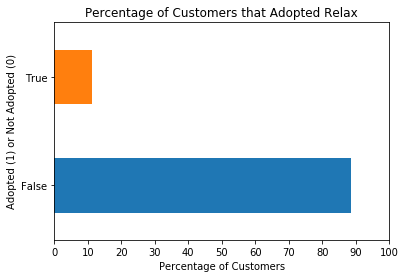

In [57]:
adopted_counts.plot(kind='barh', title='Percentage of Customers that Adopted Relax', xlim=(0, 100), 
                    xticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], color=current_palette)
plt.xlabel('Percentage of Customers')
plt.ylabel('Adopted (1) or Not Adopted (0)')
plt.show()

In order to run correlations in conjunction with covariance matrices, a quick Pearson's R function is written.

In [58]:
def pearson_r(x, y):
    corr_mat = np.corrcoef(x, y)
    return corr_mat[0, 1]

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 19 columns):
last_session_creation_time            12000 non-null float64
opted_in_to_mailing_list              12000 non-null int64
enabled_for_marketing_drip            12000 non-null int64
org_id                                12000 non-null int64
invited_by_user_id                    12000 non-null float64
last_session_creation_time_isnull     12000 non-null bool
invited_by_user_id_isnull             12000 non-null bool
creation_time_year                    12000 non-null int64
creation_time_month                   12000 non-null int64
creation_time_day                     12000 non-null int64
creation_time_hour                    12000 non-null int64
creation_time_minute                  12000 non-null int64
creation_time_seconds                 12000 non-null int64
creation_source_GUEST_INVITE          12000 non-null uint8
creation_source_ORG_INVITE            12000 non-null uint8
crea

## 'last_session_creation_time'

First, the unix timestamp of the last login is visualized and its Pearson's correlation with the target variable is calculated.  One can see two peaks in the last session creation time. It looks like this feature shows the last session creation time for each user in the scale of the number of minutes from the origin of the first session creation, although it is unclear. Therefore, this distribution is hard to interpret. The Pearson's correlation between the 'last_session_creation_time' and the target variable 'is_adopted' is 0.37, the only notable Pearson's correlation.

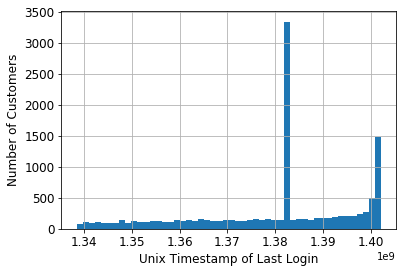

In [60]:
df['last_session_creation_time'].hist(bins=50, grid=True, xlabelsize=12, ylabelsize=12)
plt.xlabel("Unix Timestamp of Last Login", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)
plt.show()

In [61]:
r_lsct = pearson_r(df['last_session_creation_time'], df['is_adopted'])
r_lsct

0.3705285161958766

In [62]:
cov_matrix_lsct = np.cov(df['last_session_creation_time'], df['is_adopted'])
cov_matrix_lsct

array([[2.83000470e+14, 1.97792388e+06],
       [1.97792388e+06, 1.00690551e-01]])

## 'opted_in_to_mailing_list'

Second, the variable storing whether users have opted into receiving marketing emails or not is visualized and its Pearson's correlation with the target variable is calculated. As can be seen, only 25% of users opted in to the mailing list.

In [63]:
oiml_counts = round(df['opted_in_to_mailing_list'].value_counts(normalize=True), 3)*100
oiml_counts

0    75.0
1    25.0
Name: opted_in_to_mailing_list, dtype: float64

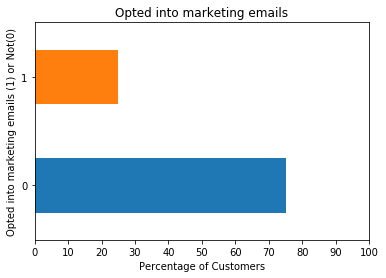

In [64]:
oiml_counts.plot(kind='barh', title='Opted into marketing emails', xlim=(0, 100), 
                    xticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], color=current_palette)
plt.xlabel('Percentage of Customers')
plt.ylabel('Opted into marketing emails (1) or Not(0)')
plt.show()

In [65]:
r_oiml = pearson_r(df['opted_in_to_mailing_list'], df['is_adopted'])
r_oiml

0.006027631809818411

In [66]:
cov_matrix_oiml = np.cov(df['opted_in_to_mailing_list'], df['is_adopted'])
cov_matrix_oiml

array([[0.18726536, 0.00082769],
       [0.00082769, 0.10069055]])

## 'enabled_for_marketing_drip'

Third, the variable storing whether users are on the regular marketing email drip or not is visualized and its Pearson's correlation with the target variable is calculated. As can be seen, only 15% of users enabled their account for the marketing drip.

In [67]:
efmd_counts = round(df['enabled_for_marketing_drip'].value_counts(normalize=True), 3)*100
efmd_counts

0    85.1
1    14.9
Name: enabled_for_marketing_drip, dtype: float64

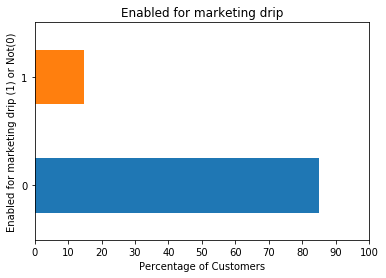

In [68]:
efmd_counts.plot(kind='barh', title='Enabled for marketing drip', xlim=(0, 100), 
                    xticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], color=current_palette)
plt.xlabel('Percentage of Customers')
plt.ylabel('Enabled for marketing drip (1) or Not(0)')
plt.show()

In [69]:
r_efmd = pearson_r(df['enabled_for_marketing_drip'], df['is_adopted'])
r_efmd

0.0018116907147076521

In [70]:
cov_matrix_efmd = np.cov(df['enabled_for_marketing_drip'], df['is_adopted'])
cov_matrix_efmd

array([[0.12704348, 0.00020491],
       [0.00020491, 0.10069055]])

## Creation Time of Account

Fourth, the discrete timedate components for creation times of user acccounts that were extracted above are visualized and their Pearson's correlation with the target variable is calculated. As can be seen, the majority of users created their account in 2013.

In [71]:
year = df['creation_time_year'].value_counts().sort_index()
year

2012    2797
2013    5676
2014    3527
Name: creation_time_year, dtype: int64

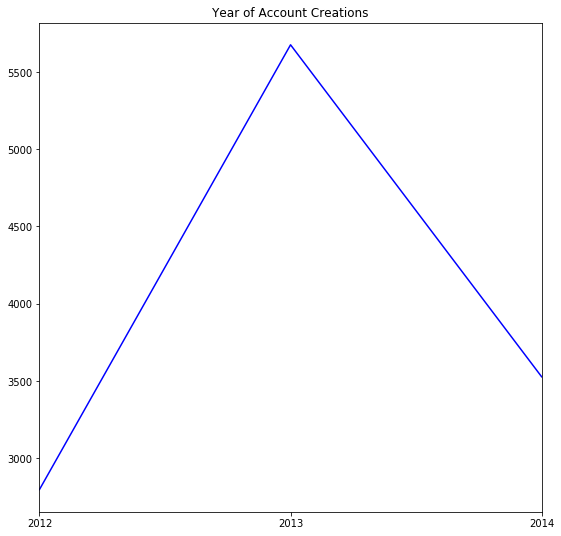

In [72]:
year.plot(xticks=[2012, 2013, 2014], figsize=(9, 9), c='blue', title='Year of Account Creations')

In [73]:
r_year = pearson_r(df['creation_time_year'], df['is_adopted'])
r_year

-0.10743248377799837

In [74]:
cov_matrix_year = np.cov(df['creation_time_year'], df['is_adopted'])
cov_matrix_year

array([[ 0.52334292, -0.02466171],
       [-0.02466171,  0.10069055]])

In [75]:
month = df['creation_time_month'].value_counts().sort_index()
month

1     1029
2      934
3     1177
4     1169
5     1455
6      841
7      852
8      852
9      901
10     924
11     936
12     930
Name: creation_time_month, dtype: int64

The majority of users created their account in May.

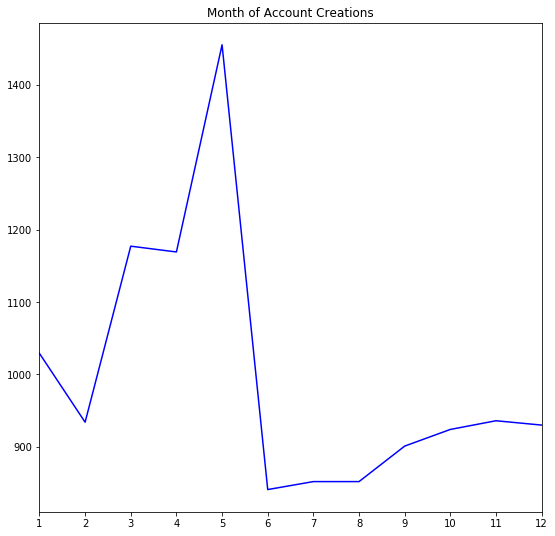

In [76]:
month.plot(xticks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], figsize=(9, 9), c='blue', title='Month of Account Creations')

In [77]:
r_month = pearson_r(df['creation_time_month'], df['is_adopted'])
r_month

0.05270596189640272

In [78]:
cov_matrix_year = np.cov(df['creation_time_month'], df['is_adopted'])
cov_matrix_year

array([[11.7235596 ,  0.05726429],
       [ 0.05726429,  0.10069055]])

In [79]:
day = df['creation_time_day'].value_counts().sort_index()
day

1     390
2     396
3     402
4     354
5     368
6     377
7     363
8     375
9     368
10    364
11    417
12    365
13    396
14    440
15    385
16    391
17    392
18    423
19    368
20    409
21    406
22    394
23    417
24    398
25    405
26    386
27    422
28    449
29    384
30    392
31    204
Name: creation_time_day, dtype: int64

As can be seen, there is no discernable pattern in the day of the month that users created their account.

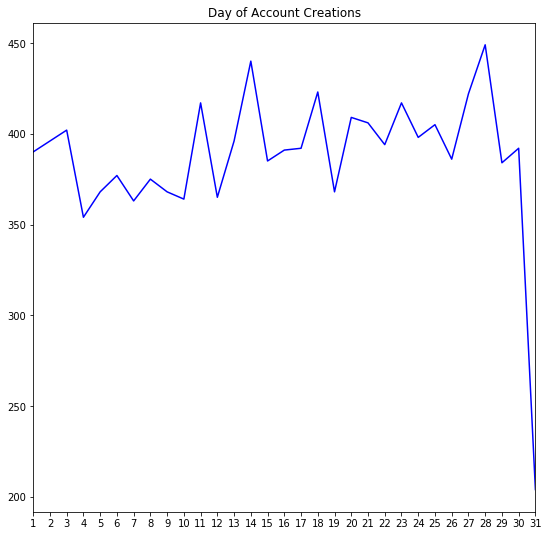

In [80]:
day.plot(xticks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 
                25, 26, 27, 28, 29, 30, 31], figsize=(9, 9), c='blue', title='Day of Account Creations')

In [81]:
r_day = pearson_r(df['creation_time_day'], df['is_adopted'])
r_day

-0.013416496123574328

In [82]:
cov_matrix_day = np.cov(df['creation_time_day'], df['is_adopted'])
cov_matrix_day

array([[ 7.75021952e+01, -3.74792135e-02],
       [-3.74792135e-02,  1.00690551e-01]])

In [83]:
hour = df['creation_time_hour'].value_counts().sort_index()
hour

0     479
1     490
2     504
3     487
4     498
5     522
6     455
7     495
8     503
9     521
10    496
11    529
12    522
13    518
14    488
15    455
16    471
17    504
18    498
19    536
20    510
21    519
22    482
23    518
Name: creation_time_hour, dtype: int64

As can be seen, there are three peaks in the distribution of the hour that users created their account: at 5 am, 9 am, 11 am, and 7 pm.

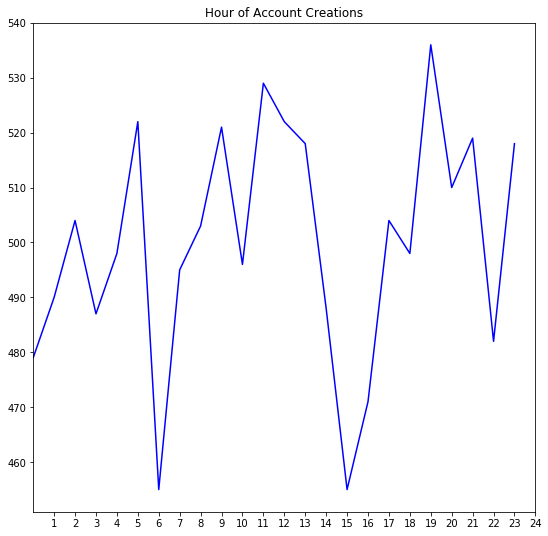

In [84]:
hour.plot(xticks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], 
          figsize=(9, 9), c='blue', title='Hour of Account Creations')

In [85]:
r_hour = pearson_r(df['creation_time_hour'], df['is_adopted'])
r_hour

0.004550737484934087

In [86]:
cov_matrix_hour = np.cov(df['creation_time_hour'], df['is_adopted'])
cov_matrix_hour

array([[4.78156792e+01, 9.98530433e-03],
       [9.98530433e-03, 1.00690551e-01]])

In [87]:
minutes = df['creation_time_minute'].value_counts().sort_index()
minutes

0     210
1     215
2     200
3     197
4     209
5     196
6     192
7     195
8     201
9     207
10    195
11    204
12    219
13    207
14    212
15    192
16    192
17    210
18    196
19    197
20    212
21    183
22    205
23    231
24    206
25    193
26    183
27    190
28    226
29    172
30    212
31    183
32    206
33    210
34    211
35    159
36    204
37    201
38    193
39    199
40    180
41    185
42    189
43    198
44    220
45    184
46    192
47    224
48    202
49    207
50    217
51    196
52    188
53    201
54    205
55    213
56    192
57    201
58    186
59    195
Name: creation_time_minute, dtype: int64

There is no discernable pattern in the minute that users created their account.

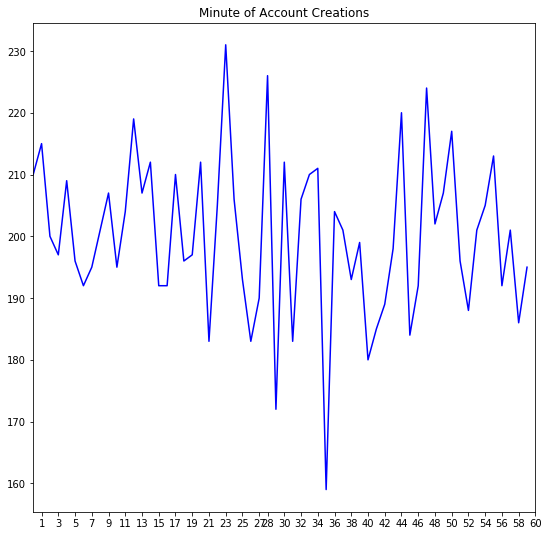

In [88]:
minutes.plot(xticks=[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 
                    48, 50, 52, 54, 56, 58, 60], 
          figsize=(9, 9), c='blue', title='Minute of Account Creations')

In [89]:
r_minutes = pearson_r(df['creation_time_minute'], df['is_adopted'])
r_minutes

0.004954972108420768

In [90]:
cov_matrix_minutes = np.cov(df['creation_time_minute'], df['is_adopted'])
cov_matrix_minutes

array([[3.01552847e+02, 2.73034350e-02],
       [2.73034350e-02, 1.00690551e-01]])

In [91]:
seconds = df['creation_time_seconds'].value_counts().sort_index()
seconds

0     203
1     195
2     206
3     180
4     230
5     204
6     177
7     198
8     218
9     205
10    197
11    203
12    190
13    175
14    176
15    200
16    200
17    202
18    172
19    194
20    203
21    234
22    191
23    206
24    209
25    172
26    239
27    213
28    197
29    200
30    224
31    199
32    181
33    208
34    229
35    219
36    192
37    209
38    165
39    170
40    203
41    205
42    219
43    201
44    213
45    219
46    179
47    195
48    187
49    218
50    191
51    221
52    187
53    188
54    199
55    202
56    187
57    227
58    192
59    182
Name: creation_time_seconds, dtype: int64

There is no discernable pattern in the second that users created their account.

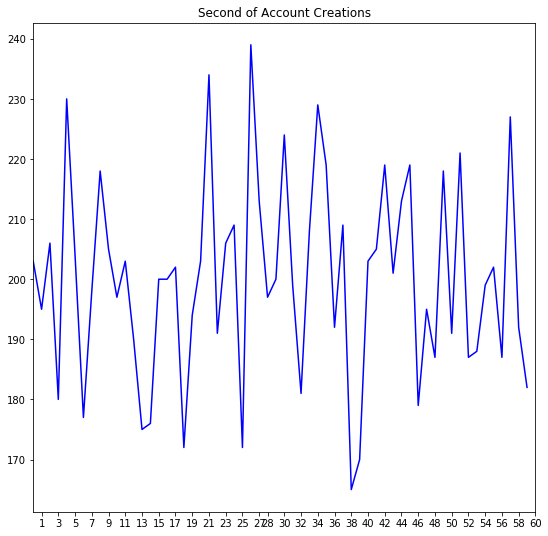

In [92]:
seconds.plot(xticks=[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 
                    48, 50, 52, 54, 56, 58, 60], 
          figsize=(9, 9), c='blue', title='Second of Account Creations')

In [93]:
r_seconds = pearson_r(df['creation_time_seconds'], df['is_adopted'])
r_seconds

-0.002989208064071932

In [94]:
cov_matrix_seconds = np.cov(df['creation_time_seconds'], df['is_adopted'])
cov_matrix_seconds

array([[ 2.97924570e+02, -1.63720727e-02],
       [-1.63720727e-02,  1.00690551e-01]])

## 'creation_source'

Finally, the variable storing how users created their Relax account is visualized and its Pearson's correlation with the target variable is calculated.

In [95]:
df_cs = pd.read_csv('relax_4_creation_source_viz.csv')
df_cs.head(1)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,last_session_creation_time_isnull,invited_by_user_id_isnull,creation_time_year,creation_time_month,creation_time_day,creation_time_hour,creation_time_minute,creation_time_seconds
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False,False,2014,4,22,3,53,30


In [96]:
source_counts = round(df_cs['creation_source'].value_counts(normalize=True), 3)*100
source_counts

ORG_INVITE            35.4
GUEST_INVITE          18.0
PERSONAL_PROJECTS     17.6
SIGNUP                17.4
SIGNUP_GOOGLE_AUTH    11.5
Name: creation_source, dtype: float64

As can be seen, the creation source that the most users created their account from is an invitation from an organization.

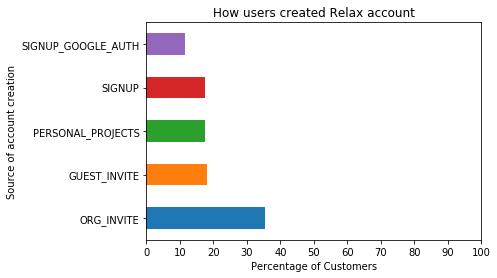

In [97]:
source_counts.plot(kind='barh', title='How users created Relax account', xlim=(0, 100), 
                    xticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], color=current_palette)
plt.xlabel('Percentage of Customers')
plt.ylabel('Source of account creation')
plt.show()

In [98]:
r_guest_invite = pearson_r(df['creation_source_GUEST_INVITE'], df['is_adopted'])
r_guest_invite

0.04394455942649682

In [99]:
cov_matrix_guest_invite = np.cov(df['creation_source_GUEST_INVITE'], df['is_adopted'])
cov_matrix_guest_invite

array([[0.14777225, 0.00536038],
       [0.00536038, 0.10069055]])

In [100]:
r_org_invite = pearson_r(df['creation_source_ORG_INVITE'], df['is_adopted'])
r_org_invite

-0.014375201748258244

In [101]:
cov_matrix_org_invite = np.cov(df['creation_source_ORG_INVITE'], df['is_adopted'])
cov_matrix_org_invite

array([[ 0.22884882, -0.00218214],
       [-0.00218214,  0.10069055]])

In [102]:
r_personal_projects = pearson_r(df['creation_source_PERSONAL_PROJECTS'], df['is_adopted'])
r_personal_projects

-0.06951103039749316

In [103]:
cov_matrix_personal_projects = np.cov(df['creation_source_PERSONAL_PROJECTS'], df['is_adopted'])
cov_matrix_personal_projects

array([[ 0.14498207, -0.00839857],
       [-0.00839857,  0.10069055]])

In [104]:
r_signup = pearson_r(df['creation_source_SIGNUP'], df['is_adopted'])
r_signup

0.017981413188279873

In [105]:
cov_matrix_signup = np.cov(df['creation_source_SIGNUP'], df['is_adopted'])
cov_matrix_signup

array([[0.14368163, 0.00216281],
       [0.00216281, 0.10069055]])

In [106]:
r_signup_google_auth = pearson_r(df['creation_source_SIGNUP_GOOGLE_AUTH'], df['is_adopted'])
r_signup_google_auth

0.030154493546089487

In [107]:
cov_matrix_signup_google_auth = np.cov(df['creation_source_SIGNUP_GOOGLE_AUTH'], df['is_adopted'])
cov_matrix_signup_google_auth

array([[0.10210417, 0.00305751],
       [0.00305751, 0.10069055]])

## Summary of EDA

The only notable Pearson's correlation was between the 'last_session_creation_time' feature and the 'is_adopted' target variable, which was 0.37. So it can be seen that as the last session creation time moves forward in time, users become more likely to be adopted.

## Machine Learning: Optimizing the Classification Algorithm

First, the 'adopted' target variable is examined to determine if the two classes 'adopted' and 'not adopted' are balanced or imbalanced.

In [108]:
df['is_adopted'].value_counts()

False    10637
True      1363
Name: is_adopted, dtype: int64

In [109]:
df['is_adopted'].value_counts(normalize=True)

False    0.886417
True     0.113583
Name: is_adopted, dtype: float64

Only 11% of users were adopted users, so the classes are imbalanced. Therefore, a train/test split is first created and then a class balancing procedure is first carried out.

In [110]:
y = df['is_adopted']

In [111]:
target_names = ['is_adopted']
X = df[[cn for cn in df.columns if cn not in target_names]]

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

First, the training data is concatenated back together.

In [113]:
X = pd.concat([X_train, y_train], axis=1)

Then, the minority and majority classes are separated.

In [114]:
not_adopted = X[X.is_adopted == 0]
adopted = X[X.is_adopted == 1]

Then, the minority class (i.e., adopted) is upsampled.

In [115]:
from sklearn.utils import resample

In [116]:
adopted_upsampled = resample(adopted,
                          replace=True, # sample with replacement
                          n_samples=len(not_adopted), # match number in majority class
                          random_state=27) # reproducible results

Then, the majority and upsampled minority classes are combined.

In [117]:
upsampled = pd.concat([not_adopted, adopted_upsampled])

The new class counts are checked.

In [118]:
upsampled.is_adopted.value_counts()

True     8510
False    8510
Name: is_adopted, dtype: int64

The 'y_train' target and 'X_train' feature set is then re-defined.

In [119]:
y_train = upsampled.is_adopted

In [120]:
X_train = upsampled.drop('is_adopted', axis=1)

In [121]:
lr_1 = linear_model.LogisticRegression(penalty='l2', C=0.001, solver='lbfgs', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [122]:
lr_pred_1 = lr_1.predict(X_test)
lr_pred_1[0:35]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [123]:
accuracy_score(y_test, lr_pred_1)

0.11375

In [124]:
print(confusion_matrix(y_test, lr_pred_1))

[[   0 2127]
 [   0  273]]


In [125]:
print(classification_report(y_test, lr_pred_1))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00      2127
        True       0.11      1.00      0.20       273

   micro avg       0.11      0.11      0.11      2400
   macro avg       0.06      0.50      0.10      2400
weighted avg       0.01      0.11      0.02      2400



/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [126]:
lr_2 = linear_model.LogisticRegression(penalty='l2', C=0.01, solver='lbfgs', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [128]:
lr_pred_2 = lr_2.predict(X_test)
lr_pred_2[0:35]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [129]:
accuracy_score(y_test, lr_pred_2)

0.11375

In [130]:
print(confusion_matrix(y_test, lr_pred_2))

[[   0 2127]
 [   0  273]]


In [131]:
print(classification_report(y_test, lr_pred_2))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00      2127
        True       0.11      1.00      0.20       273

   micro avg       0.11      0.11      0.11      2400
   macro avg       0.06      0.50      0.10      2400
weighted avg       0.01      0.11      0.02      2400



/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [132]:
lr_3 = linear_model.LogisticRegression(penalty='l2', C=0.1, solver='lbfgs', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [133]:
lr_pred_3 = lr_3.predict(X_test)
lr_pred_3[0:35]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [134]:
accuracy_score(y_test, lr_pred_3)

0.11375

In [135]:
print(confusion_matrix(y_test, lr_pred_3))

[[   0 2127]
 [   0  273]]


In [136]:
print(classification_report(y_test, lr_pred_3))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00      2127
        True       0.11      1.00      0.20       273

   micro avg       0.11      0.11      0.11      2400
   macro avg       0.06      0.50      0.10      2400
weighted avg       0.01      0.11      0.02      2400



/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [138]:
lr_4 = linear_model.LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [139]:
lr_pred_4 = lr_4.predict(X_test)
lr_pred_4[0:35]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [140]:
accuracy_score(y_test, lr_pred_4)

0.11375

In [141]:
print(confusion_matrix(y_test, lr_pred_4))

[[   0 2127]
 [   0  273]]


In [142]:
print(classification_report(y_test, lr_pred_4))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00      2127
        True       0.11      1.00      0.20       273

   micro avg       0.11      0.11      0.11      2400
   macro avg       0.06      0.50      0.10      2400
weighted avg       0.01      0.11      0.02      2400



/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [143]:
lr_5 = linear_model.LogisticRegression(penalty='l2', C=10.0, solver='lbfgs', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [144]:
lr_pred_5 = lr_5.predict(X_test)
lr_pred_5[0:35]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [145]:
accuracy_score(y_test, lr_pred_5)

0.11375

In [146]:
print(confusion_matrix(y_test, lr_pred_5))

[[   0 2127]
 [   0  273]]


In [147]:
print(classification_report(y_test, lr_pred_5))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00      2127
        True       0.11      1.00      0.20       273

   micro avg       0.11      0.11      0.11      2400
   macro avg       0.06      0.50      0.10      2400
weighted avg       0.01      0.11      0.02      2400



/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [148]:
lr_6 = linear_model.LogisticRegression(penalty='l2', C=100.0, solver='lbfgs', max_iter=12000, tol=0.001).fit(X_train, y_train)

In [149]:
lr_pred_6 = lr_6.predict(X_test)
lr_pred_6[0:35]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [150]:
accuracy_score(y_test, lr_pred_6)

0.11375

In [151]:
confusion_matrix(y_test, lr_pred_6)

array([[   0, 2127],
       [   0,  273]])

In [152]:
print(classification_report(y_test, lr_pred_6))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00      2127
        True       0.11      1.00      0.20       273

   micro avg       0.11      0.11      0.11      2400
   macro avg       0.06      0.50      0.10      2400
weighted avg       0.01      0.11      0.02      2400



/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [153]:
lr_7 = linear_model.LogisticRegression(penalty='l1', C=0.001, solver='saga', max_iter=12000, tol=0.001).fit(X_train, y_train)

In [154]:
lr_pred_7 = lr_7.predict(X_test)
lr_pred_7[0:35]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [155]:
accuracy_score(y_test, lr_pred_7)

0.11375

In [156]:
confusion_matrix(y_test, lr_pred_7)

array([[   0, 2127],
       [   0,  273]])

In [157]:
print(classification_report(y_test, lr_pred_7))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00      2127
        True       0.11      1.00      0.20       273

   micro avg       0.11      0.11      0.11      2400
   macro avg       0.06      0.50      0.10      2400
weighted avg       0.01      0.11      0.02      2400



/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [158]:
lr_8 = linear_model.LogisticRegression(penalty='l1', C=0.01, solver='saga', max_iter=12000, tol=0.001).fit(X_train, y_train)

In [159]:
lr_pred_8 = lr_8.predict(X_test)
lr_pred_8[0:35]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [160]:
accuracy_score(y_test, lr_pred_8)

0.11375

In [161]:
confusion_matrix(y_test, lr_pred_8)

array([[   0, 2127],
       [   0,  273]])

In [162]:
print(classification_report(y_test, lr_pred_8))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00      2127
        True       0.11      1.00      0.20       273

   micro avg       0.11      0.11      0.11      2400
   macro avg       0.06      0.50      0.10      2400
weighted avg       0.01      0.11      0.02      2400



/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [163]:
lr_9 = linear_model.LogisticRegression(penalty='l1', C=0.1, solver='saga', max_iter=12000, tol=0.001).fit(X_train, y_train)

In [164]:
lr_pred_9 = lr_9.predict(X_test)
lr_pred_9[0:35]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [165]:
accuracy_score(y_test, lr_pred_9)

0.11375

In [166]:
confusion_matrix(y_test, lr_pred_9)

array([[   0, 2127],
       [   0,  273]])

In [167]:
print(classification_report(y_test, lr_pred_9))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00      2127
        True       0.11      1.00      0.20       273

   micro avg       0.11      0.11      0.11      2400
   macro avg       0.06      0.50      0.10      2400
weighted avg       0.01      0.11      0.02      2400



/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [168]:
lr_10 = linear_model.LogisticRegression(penalty='l1', C=1.0, solver='saga', max_iter=12000, tol=0.001).fit(X_train, y_train)

In [169]:
lr_pred_10 = lr_10.predict(X_test)
lr_pred_10[0:35]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [170]:
accuracy_score(y_test, lr_pred_10)

0.11375

In [171]:
confusion_matrix(y_test, lr_pred_10)

array([[   0, 2127],
       [   0,  273]])

In [172]:
print(classification_report(y_test, lr_pred_10))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00      2127
        True       0.11      1.00      0.20       273

   micro avg       0.11      0.11      0.11      2400
   macro avg       0.06      0.50      0.10      2400
weighted avg       0.01      0.11      0.02      2400



/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [173]:
lr_11 = linear_model.LogisticRegression(penalty='l1', C=10, solver='saga', max_iter=12000, tol=0.001).fit(X_train, y_train)

In [174]:
lr_pred_11 = lr_11.predict(X_test)
lr_pred_11[0:35]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [175]:
accuracy_score(y_test, lr_pred_11)

0.11375

In [176]:
confusion_matrix(y_test, lr_pred_11)

array([[   0, 2127],
       [   0,  273]])

In [177]:
print(classification_report(y_test, lr_pred_11))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00      2127
        True       0.11      1.00      0.20       273

   micro avg       0.11      0.11      0.11      2400
   macro avg       0.06      0.50      0.10      2400
weighted avg       0.01      0.11      0.02      2400



/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [178]:
lr_12 = linear_model.LogisticRegression(penalty='l1', C=100, solver='saga', max_iter=12000, tol=0.001).fit(X_train, y_train)

In [179]:
lr_pred_12 = lr_12.predict(X_test)
lr_pred_12[0:35]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [180]:
accuracy_score(y_test, lr_pred_12)

0.11375

In [181]:
confusion_matrix(y_test, lr_pred_12)

array([[   0, 2127],
       [   0,  273]])

In [182]:
print(classification_report(y_test, lr_pred_12))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00      2127
        True       0.11      1.00      0.20       273

   micro avg       0.11      0.11      0.11      2400
   macro avg       0.06      0.50      0.10      2400
weighted avg       0.01      0.11      0.02      2400



/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [183]:
rfc_1 = RandomForestClassifier().fit(X_train, y_train)

/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [184]:
rfc_pred_1 = rfc_1.predict(X_test)

In [185]:
accuracy_score(y_test, rfc_pred_1)

0.97125

In [186]:
confusion_matrix(y_test, rfc_pred_1)

array([[2113,   14],
       [  55,  218]])

In [187]:
print(classification_report(y_test, rfc_pred_1))

              precision    recall  f1-score   support

       False       0.97      0.99      0.98      2127
        True       0.94      0.80      0.86       273

   micro avg       0.97      0.97      0.97      2400
   macro avg       0.96      0.90      0.92      2400
weighted avg       0.97      0.97      0.97      2400



In [188]:
rfc_2 = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)

In [189]:
rfc_pred_2 = rfc_2.predict(X_test)

In [190]:
accuracy_score(y_test, rfc_pred_2)

0.9708333333333333

In [191]:
confusion_matrix(y_test, rfc_pred_2)

array([[2105,   22],
       [  48,  225]])

In [192]:
print(classification_report(y_test, rfc_pred_2))

              precision    recall  f1-score   support

       False       0.98      0.99      0.98      2127
        True       0.91      0.82      0.87       273

   micro avg       0.97      0.97      0.97      2400
   macro avg       0.94      0.91      0.92      2400
weighted avg       0.97      0.97      0.97      2400



## Scaled Data

Scaled data is experimented with next to see if the models perform differently. The classes are balanced again, as before.

In [193]:
scaler = MinMaxScaler()

In [194]:
scaler.fit(df)

/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


MinMaxScaler(copy=True, feature_range=(0, 1))

In [195]:
df_scaled = pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)

In [196]:
df_scaled.head()

,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,last_session_creation_time_isnull,invited_by_user_id_isnull,creation_time_year,creation_time_month,creation_time_day,creation_time_hour,creation_time_minute,creation_time_seconds,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,is_adopted
object_id,,,,,,,,,,,,,,,,,,,
1,0.938254,1.0,0.0,0.026442,0.900325,0.0,0.0,1.0,0.272727,0.700000,0.130435,0.898305,0.508475,1.0,0.0,0.0,0.0,0.0,0.0
2,0.908366,0.0,0.0,0.002404,0.026336,0.0,0.0,0.5,0.909091,0.466667,0.130435,0.762712,0.067797,0.0,1.0,0.0,0.0,0.0,0.0
3,0.397434,0.0,0.0,0.225962,0.127094,0.0,0.0,0.5,0.181818,0.600000,1.000000,0.237288,0.881356,0.0,1.0,0.0,0.0,0.0,0.0
4,0.483504,0.0,0.0,0.002404,0.429286,0.0,0.0,0.5,0.363636,0.666667,0.347826,0.152542,0.474576,1.0,0.0,0.0,0.0,0.0,0.0
5,0.320639,0.0,0.0,0.463942,0.436703,0.0,0.0,0.5,0.000000,0.533333,0.434783,0.237288,0.338983,1.0,0.0,0.0,0.0,0.0,0.0


In [198]:
y = df_scaled['is_adopted']

In [199]:
target_names = ['is_adopted']
X = df_scaled[[cn for cn in df_scaled.columns if cn not in target_names]]

In [200]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

First, the training data is concatenated back together.

In [201]:
X = pd.concat([X_train, y_train], axis=1)

Then, the minority and majority classes are separated.

In [202]:
not_adopted = X[X.is_adopted == 0]
adopted = X[X.is_adopted == 1]

Then, the minority class (i.e., adopted) is upsampled.

In [203]:
adopted_upsampled = resample(adopted,
                          replace=True, # sample with replacement
                          n_samples=len(not_adopted), # match number in majority class
                          random_state=27) # reproducible results

Then, the majority and upsampled minority classes are combined.

In [204]:
upsampled = pd.concat([not_adopted, adopted_upsampled])

The new class counts are checked.

In [206]:
upsampled.is_adopted.value_counts()

1.0    8510
0.0    8510
Name: is_adopted, dtype: int64

The 'y_train' target and 'X_train' feature set is then re-defined.

In [207]:
y_train = upsampled.is_adopted

In [208]:
X_train = upsampled.drop('is_adopted', axis=1)

In [209]:
lr_13 = linear_model.LogisticRegression(penalty='l2', C=0.001, solver='lbfgs', max_iter=12000, tol=0.001).fit(X_train, y_train)

In [210]:
lr_pred_13 = lr_13.predict(X_test)
lr_pred_13[0:35]

array([0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
       1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       0.])

In [211]:
accuracy_score(y_test, lr_pred_13)

0.7795833333333333

In [212]:
confusion_matrix(y_test, lr_pred_13)

array([[1625,  502],
       [  27,  246]])

In [213]:
print(classification_report(y_test, lr_pred_13))

              precision    recall  f1-score   support

         0.0       0.98      0.76      0.86      2127
         1.0       0.33      0.90      0.48       273

   micro avg       0.78      0.78      0.78      2400
   macro avg       0.66      0.83      0.67      2400
weighted avg       0.91      0.78      0.82      2400



In [214]:
lr_14 = linear_model.LogisticRegression(penalty='l2', C=0.01, solver='lbfgs', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [215]:
lr_pred_14 = lr_14.predict(X_test)
lr_pred_14[0:35]

array([0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0.])

In [216]:
accuracy_score(y_test, lr_pred_14)

0.90375

In [217]:
print(confusion_matrix(y_test, lr_pred_14))

[[1923  204]
 [  27  246]]


In [218]:
print(classification_report(y_test, lr_pred_14))

              precision    recall  f1-score   support

         0.0       0.99      0.90      0.94      2127
         1.0       0.55      0.90      0.68       273

   micro avg       0.90      0.90      0.90      2400
   macro avg       0.77      0.90      0.81      2400
weighted avg       0.94      0.90      0.91      2400



In [219]:
lr_15 = linear_model.LogisticRegression(penalty='l2', C=0.1, solver='lbfgs', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [220]:
lr_pred_15 = lr_15.predict(X_test)
lr_pred_15[0:35]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [221]:
accuracy_score(y_test, lr_pred_15)

0.9725

In [222]:
print(confusion_matrix(y_test, lr_pred_15))

[[2087   40]
 [  26  247]]


In [223]:
print(classification_report(y_test, lr_pred_15))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      2127
         1.0       0.86      0.90      0.88       273

   micro avg       0.97      0.97      0.97      2400
   macro avg       0.92      0.94      0.93      2400
weighted avg       0.97      0.97      0.97      2400



In [224]:
lr_16 = linear_model.LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [225]:
lr_pred_16 = lr_16.predict(X_test)
lr_pred_16[0:35]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [226]:
accuracy_score(y_test, lr_pred_16)

0.9720833333333333

In [227]:
print(confusion_matrix(y_test, lr_pred_16))

[[2077   50]
 [  17  256]]


In [228]:
print(classification_report(y_test, lr_pred_16))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      2127
         1.0       0.84      0.94      0.88       273

   micro avg       0.97      0.97      0.97      2400
   macro avg       0.91      0.96      0.93      2400
weighted avg       0.97      0.97      0.97      2400



In [229]:
lr_17 = linear_model.LogisticRegression(penalty='l2', C=10.0, solver='lbfgs', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [230]:
lr_pred_17 = lr_17.predict(X_test)
lr_pred_17[0:35]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [231]:
accuracy_score(y_test, lr_pred_17)

0.9691666666666666

In [232]:
print(confusion_matrix(y_test, lr_pred_17))

[[2062   65]
 [   9  264]]


In [233]:
print(classification_report(y_test, lr_pred_17))

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98      2127
         1.0       0.80      0.97      0.88       273

   micro avg       0.97      0.97      0.97      2400
   macro avg       0.90      0.97      0.93      2400
weighted avg       0.97      0.97      0.97      2400



In [234]:
lr_18 = linear_model.LogisticRegression(penalty='l2', C=100.0, solver='lbfgs', max_iter=12000, tol=0.001).fit(X_train, y_train)

In [235]:
lr_pred_18 = lr_18.predict(X_test)
lr_pred_18[0:35]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [236]:
accuracy_score(y_test, lr_pred_18)

0.9679166666666666

In [237]:
confusion_matrix(y_test, lr_pred_18)

array([[2058,   69],
       [   8,  265]])

In [238]:
print(classification_report(y_test, lr_pred_18))

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98      2127
         1.0       0.79      0.97      0.87       273

   micro avg       0.97      0.97      0.97      2400
   macro avg       0.89      0.97      0.93      2400
weighted avg       0.97      0.97      0.97      2400



In [239]:
lr_19 = linear_model.LogisticRegression(penalty='l1', C=0.001, solver='saga', max_iter=12000, tol=0.001).fit(X_train, y_train)

In [240]:
lr_pred_19 = lr_19.predict(X_test)
lr_pred_19[0:35]

array([0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1.,
       1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1.,
       0.])

In [241]:
accuracy_score(y_test, lr_pred_19)

0.7429166666666667

In [242]:
confusion_matrix(y_test, lr_pred_19)

array([[1537,  590],
       [  27,  246]])

In [243]:
print(classification_report(y_test, lr_pred_19))

              precision    recall  f1-score   support

         0.0       0.98      0.72      0.83      2127
         1.0       0.29      0.90      0.44       273

   micro avg       0.74      0.74      0.74      2400
   macro avg       0.64      0.81      0.64      2400
weighted avg       0.90      0.74      0.79      2400



In [244]:
lr_20 = linear_model.LogisticRegression(penalty='l1', C=0.01, solver='saga', max_iter=12000, tol=0.001).fit(X_train, y_train)

In [245]:
lr_pred_20 = lr_20.predict(X_test)
lr_pred_20[0:35]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [246]:
accuracy_score(y_test, lr_pred_20)

0.9716666666666667

In [247]:
confusion_matrix(y_test, lr_pred_20)

array([[2087,   40],
       [  28,  245]])

In [248]:
print(classification_report(y_test, lr_pred_20))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      2127
         1.0       0.86      0.90      0.88       273

   micro avg       0.97      0.97      0.97      2400
   macro avg       0.92      0.94      0.93      2400
weighted avg       0.97      0.97      0.97      2400



In [249]:
lr_21 = linear_model.LogisticRegression(penalty='l1', C=0.1, solver='saga', max_iter=12000, tol=0.001).fit(X_train, y_train)

In [250]:
lr_pred_21 = lr_21.predict(X_test)
lr_pred_21[0:35]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [251]:
accuracy_score(y_test, lr_pred_21)

0.9708333333333333

In [252]:
confusion_matrix(y_test, lr_pred_21)

array([[2071,   56],
       [  14,  259]])

In [253]:
print(classification_report(y_test, lr_pred_21))

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      2127
         1.0       0.82      0.95      0.88       273

   micro avg       0.97      0.97      0.97      2400
   macro avg       0.91      0.96      0.93      2400
weighted avg       0.97      0.97      0.97      2400



In [254]:
lr_22 = linear_model.LogisticRegression(penalty='l1', C=1.0, solver='saga', max_iter=12000, tol=0.001).fit(X_train, y_train)

In [255]:
lr_pred_22 = lr_22.predict(X_test)
lr_pred_22[0:35]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [256]:
accuracy_score(y_test, lr_pred_22)

0.9679166666666666

In [257]:
confusion_matrix(y_test, lr_pred_22)

array([[2059,   68],
       [   9,  264]])

In [258]:
print(classification_report(y_test, lr_pred_22))

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98      2127
         1.0       0.80      0.97      0.87       273

   micro avg       0.97      0.97      0.97      2400
   macro avg       0.90      0.97      0.93      2400
weighted avg       0.97      0.97      0.97      2400



In [259]:
lr_23 = linear_model.LogisticRegression(penalty='l1', C=10, solver='saga', max_iter=12000, tol=0.001).fit(X_train, y_train)

In [260]:
lr_pred_23 = lr_23.predict(X_test)
lr_pred_23[0:35]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [261]:
accuracy_score(y_test, lr_pred_23)

0.9679166666666666

In [262]:
confusion_matrix(y_test, lr_pred_23)

array([[2058,   69],
       [   8,  265]])

In [263]:
print(classification_report(y_test, lr_pred_23))

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98      2127
         1.0       0.79      0.97      0.87       273

   micro avg       0.97      0.97      0.97      2400
   macro avg       0.89      0.97      0.93      2400
weighted avg       0.97      0.97      0.97      2400



In [264]:
lr_24 = linear_model.LogisticRegression(penalty='l1', C=100, solver='saga', max_iter=12000, tol=0.001).fit(X_train, y_train)

In [265]:
lr_pred_24 = lr_24.predict(X_test)
lr_pred_24[0:35]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [266]:
accuracy_score(y_test, lr_pred_24)

0.9679166666666666

In [267]:
confusion_matrix(y_test, lr_pred_24)

array([[2058,   69],
       [   8,  265]])

In [268]:
print(classification_report(y_test, lr_pred_24))

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98      2127
         1.0       0.79      0.97      0.87       273

   micro avg       0.97      0.97      0.97      2400
   macro avg       0.89      0.97      0.93      2400
weighted avg       0.97      0.97      0.97      2400



In [269]:
rfc_1s = RandomForestClassifier().fit(X_train, y_train)

/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [270]:
rfc_pred_1s = rfc_1s.predict(X_test)

In [271]:
accuracy_score(y_test, rfc_pred_1s)

0.97

In [272]:
confusion_matrix(y_test, rfc_pred_1s)

array([[2108,   19],
       [  53,  220]])

In [273]:
print(classification_report(y_test, rfc_pred_1s))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      2127
         1.0       0.92      0.81      0.86       273

   micro avg       0.97      0.97      0.97      2400
   macro avg       0.95      0.90      0.92      2400
weighted avg       0.97      0.97      0.97      2400



In [274]:
rfc_2s = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)

In [275]:
rfc_pred_2s = rfc_2s.predict(X_test)

In [276]:
accuracy_score(y_test, rfc_pred_2s)

0.97

In [277]:
confusion_matrix(y_test, rfc_pred_2s)

array([[2102,   25],
       [  47,  226]])

In [278]:
print(classification_report(y_test, rfc_pred_2s))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      2127
         1.0       0.90      0.83      0.86       273

   micro avg       0.97      0.97      0.97      2400
   macro avg       0.94      0.91      0.92      2400
weighted avg       0.97      0.97      0.97      2400



As can be seen, the top performing classification algorithm is the Logistic Regression algorithm using scaled data, the 'lbfgs' solver, the L2 penalty, and a regularization 'C' parameter of 0.1. 

In [279]:
hp_tuning_table = pd.read_excel('Relax_HP_tuning_table.xlsx')
hp_tuning_table

,Unnamed: 0,LR_#,Accuracy_Score,Precision_Not_Retained,Precision_Retained,Precision_Average,Recall_Not_Retained,Recall_Retained,Recall_Average,F1_Score_Not_Retained,F1_Score_Retained,F1_Score_Average,Support_Not_Retained,Support_Retained,Support_Total
0,"LR, scaled, lbfgs solver, L2 penalty, C=0.1",15,0.972500,0.99,0.86,0.97,0.98,0.90,0.97,0.98,0.88,0.97,2127,273,2400
1,"LR, scaled, lbfgs solver, L2 penalty, C=1.0",16,0.972083,0.99,0.84,0.97,0.98,0.94,0.97,0.98,0.88,0.97,2127,273,2400
2,"LR, scaled, saga solver, L1 penalty, C=0.01",20,0.971667,0.99,0.86,0.97,0.98,0.90,0.97,0.98,0.88,0.97,2127,273,2400
3,"RF, unscaled, 10 n_estimators","rfc_1, 10 estimators",0.971250,0.97,0.94,0.97,0.99,0.80,0.97,0.98,0.86,0.97,2127,273,2400
4,"LR, scaled, saga solver, L1 penalty, C=0.1",21,0.970833,0.99,0.82,0.97,0.97,0.95,0.97,0.98,0.88,0.97,2127,273,2400
5,"RF, unscaled, 100 n_estimators","rfc_2, 100 estimators",0.970833,0.98,0.91,0.97,0.99,0.82,0.97,0.98,0.87,0.97,2127,273,2400
6,"RF, scaled, 10 n_estimators","rfc_1s, 10 estimators",0.970000,0.98,0.92,0.97,0.99,0.81,0.97,0.98,0.86,0.97,2127,273,2400
7,"RF, scaled, 100 n_estimators","rfc_2s, 100 estimators",0.970000,0.98,0.90,0.97,0.99,0.83,0.97,0.98,0.86,0.97,2127,273,2400
8,"LR, scaled, lbfgs solver, L2 penalty, C=10.0",17,0.969167,1.00,0.80,0.97,0.97,0.97,0.97,0.98,0.88,0.97,2127,273,2400
9,"LR, scaled, lbfgs solver, L2 penalty, C=100.0",18,0.967917,1.00,0.79,0.97,0.97,0.97,0.97,0.98,0.87,0.97,2127,273,2400


## ROC curve and AUC

The Receiver Operating Characteristic (ROC) curve and Area Under the Curve (AUC) are called on the best performing LogisticRegression algorithm ('lr_15'). This is done to further evaluate the model.

First, the ROC curve for the best performing LogisticRegression model ('lr_15') is calculated and plotted, and its AUC score is returned.

In [280]:
y_pred_prob_lr_15 = lr_15.predict_proba(X_test)[:,1]
y_pred_prob_lr_15

array([0.06319767, 0.09607917, 0.35282332, ..., 0.26718684, 0.08021157,
       0.12506306])

In [281]:
fpr_lr_15, tpr_lr_15, thresholds_lr_15 = roc_curve(y_test, y_pred_prob_lr_15)

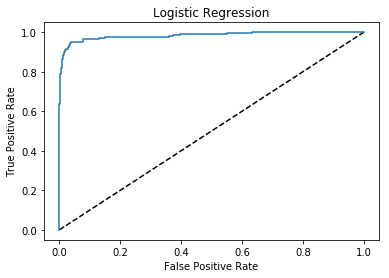

In [282]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr_15, tpr_lr_15, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression')
plt.show();

In [283]:
auc_score_lr_15 = roc_auc_score(y_test, y_pred_prob_lr_15)
auc_score_lr_15

0.9836223954700681

## Precision Recall Curve

Because of the imbalanced class count, the 15th LogisticRegression algorithm is evaluated below with a Precision-Recall Curve, as recommended by this article by Jason Brownlee, PhD: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/. As Dr. Brownlee says, the future performance of a model with imbalanced class counts is better evaluated with a Precision-Recall Curve than an ROC curve. Specific modules are first imported for use in calculating the Precision-Recall Curve.

In [284]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

The precision recall curve is defined below, as is the F1 score and AUC for the precision-recall curve.

In [285]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred_prob_lr_15)

In [286]:
lr_f1, lr_auc = f1_score(y_test, lr_pred_15), auc(lr_recall, lr_precision)

The F1 score is then called, as is the area under the Precision Recall Curve.

In [287]:
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

Logistic: f1=0.882 auc=0.948


The precision-recall curve is then plotted for the best Logistic Regression algorithm ('lr_15'). The precision-recall curve's AUC score (0.948) is lower than the ROC curve's AUC (0.984), showing that the model is skilled at differentiating true positives from false positives and false negatives.

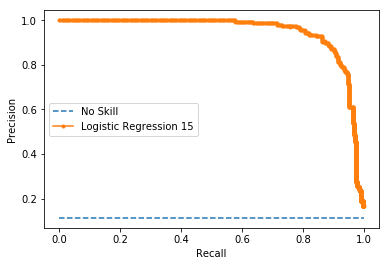

In [288]:
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic Regression 15')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## Coefficients

In order to look at the most salient predictors of adopted Relax customers, the feature set's coefficients for the best performing Logistic Regression algorithm ('lr_15') are identified to find the most predictive features differentiating adopted customers from non-adopted customers.

First, the coefficients are scaled as the features in the predictive feature set are of multiple scales, including binary, 5-point ratings, percentiles, and real integer numbers.

First, the coefficients are called for all the features in the feature set, assigned to 'best_cf_coeffs' (short for 'best classifier's coefficients').

In [289]:
best_cf_coeffs = pd.Series(lr_15.coef_[0], index=X_train.columns) 
best_cf_coeffs

last_session_creation_time            10.172719
opted_in_to_mailing_list              -0.020610
enabled_for_marketing_drip             0.002489
org_id                                 0.424256
invited_by_user_id                    -0.080541
last_session_creation_time_isnull     -5.747519
invited_by_user_id_isnull             -0.076398
creation_time_year                    -7.695870
creation_time_month                   -2.980415
creation_time_day                     -0.343844
creation_time_hour                     0.021917
creation_time_minute                  -0.127037
creation_time_seconds                 -0.002576
creation_source_GUEST_INVITE           0.159554
creation_source_ORG_INVITE            -0.082955
creation_source_PERSONAL_PROJECTS      0.083534
creation_source_SIGNUP                -0.052854
creation_source_SIGNUP_GOOGLE_AUTH    -0.107077
dtype: float64

In [290]:
lr_15_coeffs_sorted = best_cf_coeffs.sort_values(ascending=False)
lr_15_coeffs_sorted

last_session_creation_time            10.172719
org_id                                 0.424256
creation_source_GUEST_INVITE           0.159554
creation_source_PERSONAL_PROJECTS      0.083534
creation_time_hour                     0.021917
enabled_for_marketing_drip             0.002489
creation_time_seconds                 -0.002576
opted_in_to_mailing_list              -0.020610
creation_source_SIGNUP                -0.052854
invited_by_user_id_isnull             -0.076398
invited_by_user_id                    -0.080541
creation_source_ORG_INVITE            -0.082955
creation_source_SIGNUP_GOOGLE_AUTH    -0.107077
creation_time_minute                  -0.127037
creation_time_day                     -0.343844
creation_time_month                   -2.980415
last_session_creation_time_isnull     -5.747519
creation_time_year                    -7.695870
dtype: float64

Second, the coefficients are scaled as the features in the predictive feature set are of multiple scales, including binary, 5-point ratings, percentiles, and real integer numbers.

In [291]:
normalized_lr_15_coeffs = best_cf_coeffs/(X_train.max() - X_train.min())
normalized_lr_15_coeffs

last_session_creation_time            10.172719
opted_in_to_mailing_list              -0.020610
enabled_for_marketing_drip             0.002489
org_id                                 0.424256
invited_by_user_id                    -0.080541
last_session_creation_time_isnull     -5.747519
invited_by_user_id_isnull             -0.076398
creation_time_year                    -7.695870
creation_time_month                   -2.980415
creation_time_day                     -0.343844
creation_time_hour                     0.021917
creation_time_minute                  -0.127037
creation_time_seconds                 -0.002576
creation_source_GUEST_INVITE           0.159554
creation_source_ORG_INVITE            -0.082955
creation_source_PERSONAL_PROJECTS      0.083534
creation_source_SIGNUP                -0.052854
creation_source_SIGNUP_GOOGLE_AUTH    -0.107077
dtype: float64

The features' coefficients are then sorted to show the features most predictive of adopted Relax customers. The features with positive coefficients are more predictive of adopted Relax customers, while the features with negative coefficients are more predictive of non-adopted Relax customers.

In [293]:
norm_best_coeffs = normalized_lr_15_coeffs.sort_values(ascending=False)
norm_best_coeffs

last_session_creation_time            10.172719
org_id                                 0.424256
creation_source_GUEST_INVITE           0.159554
creation_source_PERSONAL_PROJECTS      0.083534
creation_time_hour                     0.021917
enabled_for_marketing_drip             0.002489
creation_time_seconds                 -0.002576
opted_in_to_mailing_list              -0.020610
creation_source_SIGNUP                -0.052854
invited_by_user_id_isnull             -0.076398
invited_by_user_id                    -0.080541
creation_source_ORG_INVITE            -0.082955
creation_source_SIGNUP_GOOGLE_AUTH    -0.107077
creation_time_minute                  -0.127037
creation_time_day                     -0.343844
creation_time_month                   -2.980415
last_session_creation_time_isnull     -5.747519
creation_time_year                    -7.695870
dtype: float64

As can be seen, there are several features with interesting logistic regression coefficients that can guide Relax's efforts to increase customer adoption. These include:

- 'last_session_creation_time': 10.2  This feature has the highest logistic regression coefficient by far, which mirrors its Pearson's correlation with the 'is_adopted' target variable. This again shows that users whose last session was created recently are more likely to be adopted users, which makes perfect sense.

- 'org_id': 0.42  This is an interesting finding that shows that there is some relationship between users with larger org ids and Relax adoption. Perhaps the org id is assigned in a sequential growing sequence as users sign up for Relax, which reflects the logistic regression coefficient of 'last_session_creation_time', showing that users who signed up more recently are more likely to be adopted users. This may reflect a more general improvement in the user experience of Relax.

- 'creation_time_day': -0.34  This simply shows that users who create their account later in the month are less likely to be Relax adopters. This may warrant some research into whether internal processes at Relax that are happening later in the month may be interfering with the user experience of Relax users.

- 'creation_time_month': -2.98  This simply shows that users who create their account later in the year are less likely to be Relax adopters. This may warrant some research into whether internal processes at Relax that are happening later in the year may be interfering with the user experience of Relax users.

- 'creation_time_year': -7.7  This simply shows that users who create their account later in later years are less likely to be Relax adopters. This may warrant some research into whether internal processes at Relax that are happening in 2014 versus 2013 may be interfering with the user experience of Relax users.

These features are the most important features in predicting product adoption for Relax users.